In [1]:
%matplotlib inline

import os
import numpy as np
import pandas as pd
import networkx as nx

from collections import defaultdict

import scipy.sparse as spsparse
import matplotlib.pylab as plt


import pyscisci.all as pyscisci


In [2]:
# set this path to where the MAG database is stored
path2mag = '/home/ajgates/MAG'
path2mag = '/Volumes/GatesExpansionDrive/DataSets/MAG'

# apply a global filter to keep only journal articles
docfilter = pyscisci.DocTypeFilter(doctypes=['j'])

mymag = pyscisci.MAG(path2mag, keep_in_memory=False, global_filter = docfilter, show_progress=True) 
# set keep_in_memory=False if you want to load the database each time its needed 
# otherwise keep_in_memory=True will keep each database in memory after its loaded

# global_filter will only load publications that match the filtering criteria

In [3]:
# we will focus on a seminal paper that both meausres and embodies interdisciplinarity:

# A general framework for analysing diversity in science, technology and society
# Andrew Stirling

focus_publication_id = 2110158660


In [4]:
# First we load all of the publications citing our focus publication
citing_pub2ref_df = mymag.load_references(filter_dict={'CitedPublicationId':np.sort([focus_publication_id])})

# Then we need all of these articles references
pub2ref_df = mymag.load_references(filter_dict={'CitingPublicationId':np.sort(citing_pub2ref_df['CitingPublicationId'].unique())})


In [6]:
# now lets get the field information

finfo = mymag.fieldinfo_df

# we'll take the fields at level 0
lvl0fields = finfo.loc[finfo['FieldLevel'] == 0][['FieldID', 'FieldName']]
fid2name = {fid:fname for fid, fname in lvl0fields.values}


# load the mapping of the publication to the fields, only for the publications and fields we care about
pub2field_df = mymag.load_pub2field(filter_dict={'PublicationId':np.sort(pub2ref_df['CitedPublicationId'].unique()), 
                                              'FieldId':np.sort(lvl0fields['FieldID'].unique())})


In [7]:

focus_citing_pubs = np.sort(pub2ref_df.loc[pub2ref_df['CitedPublicationId'] == focus_publication_id]['CitingPublicationId'].unique())



In [8]:
# we are going to make the co-citation network between all of the publications that cited our focus publication
cocitenet, cocite2int = pyscisci.cocitation_network(pub2ref_df, focus_pub_ids=focus_citing_pubs, 
                                        focus_constraint='cited', 
                                        temporal=False, show_progress=False)

# cocitenet is our network adjcency matrix
# cocite2int maps the publication ids to the row/col of the adjcency matrix
print("{0} nodes, and {1} edges".format(len(cocite2int), cocitenet.nnz))




108 nodes, and 1378 edges


In [9]:
mat = cocitenet.copy()
mat.setdiag(0)

mat.data[mat.data <=1] = 0
mat.eliminate_zeros()

In [10]:
n_components, labels = spsparse.csgraph.connected_components(mat)
print(n_components)
comidx, compsizes = np.unique(labels, return_counts=True)
print(max(compsizes))

lccidx = np.argmax(compsizes)

lcc = labels==lccidx
lccnodes = np.arange(mat.shape[0])[lcc]
remapnodes = {nid:i for i, nid in enumerate(lccnodes)}
cocite2int = {pid:remapnodes[i] for pid, i in cocite2int.items() if not remapnodes.get(i, None) is None}

lccmat = spsparse.coo_matrix(spsparse.csr_matrix(mat)[lcc][:,lcc])

43
63


In [11]:
cocite_pubs = np.sort(list(cocite2int.keys()))
cocite_fields = pub2field_df.loc[pyscisci.isin_sorted(pub2field_df['PublicationId'].values, cocite_pubs)].copy()

cocite_fields.nunique()

PublicationId    62
FieldId          10
dtype: int64

In [12]:
# most publications are mapped to multiple fields, even at level 1 
# to color our nodes, lets start by seeing which fields appear the most frequently
fieldcount = cocite_fields['FieldId'].value_counts(ascending=False)

for idx in fieldcount.index.values:
    print(idx, fid2name[idx], fieldcount.get(idx))
    
    

41008148 computer science 32
162324750 economics 11
144024400 sociology 10
71924100 medicine 2
17744445 political science 2
15744967 psychology 1
33923547 mathematics 1
121332964 physics 1
86803240 biology 1
144133560 business 1


In [13]:
# we are going to take the largest 3 fields, and group together all of the remaining fields into an "other"
max_fields = 3
reorder_fields = {fid:i for i, fid in enumerate(fieldcount.index.values[:(max_fields+1)])}

cocite_fields['RemappedFields'] = [reorder_fields.get(fid, max_fields) for fid in cocite_fields['FieldId'].values]
cocite_fields.sort_values(by=['RemappedFields'], ascending=True, inplace=True)
cocite_fields.drop_duplicates(subset=['PublicationId'], keep='first', inplace=True)

cocite_fields.reset_index(inplace=True, drop=True)

In [154]:
fieldcount = cocite_fields['RemappedFields'].value_counts(ascending=False)
reorder_fields2 = {i:idx for idx, i in reorder_fields.items()}
for idx in fieldcount.index.values[:(max_fields+1)]:
    if idx < max_fields:
        print(idx, fid2name2[reorder_fields2[idx]], fieldcount.get(idx))
        
print(max_fields, "other", fieldcount.get(max_fields))        

0 computer science 41
1 economics 35
2 sociology 20
3 other 15


In [167]:
#field2color = {0:'#DE9E36', 1:'#EF6461',4:'#C287E8',3:'#DFB2F4',2:'#87BFFF'}
field2color = {0:'#E9B44C', 1:'#50A2A7',2:'#8E5572', 3:'#5E8334'}
field2node = collections.defaultdict(list)

for pid, fid in cocite_fields[['PublicationId', 'RemappedFields']].values:
    field2node[fid].append(cocite2int[pid])

In [128]:
pos = nx.drawing.nx_agraph.graphviz_layout(g, prog='sfdp')

0 [40, 71, 29, 110, 109, 54, 24, 64, 106, 51, 46, 103, 105, 47, 63, 55, 100, 31, 102, 25, 37, 84, 75, 98, 1, 43, 82, 6, 85, 83, 16, 12, 9, 97, 73, 107, 56, 18, 22, 81, 17] 41
1 [79, 67, 8, 15, 45, 77, 89, 66, 26, 99, 86, 74, 27, 38, 80, 65, 87, 93, 7, 13, 28, 4, 52, 33, 108, 21, 19, 32, 94, 35, 2, 3, 34, 53, 41] 35
2 [91, 88, 60, 57, 68, 44, 42, 95, 10, 101, 59, 30, 48, 72, 20, 76, 23, 70, 14, 78] 20
3 [5, 62, 69, 58, 36, 11, 92, 39, 61, 50, 111, 90, 49, 104, 0] 15


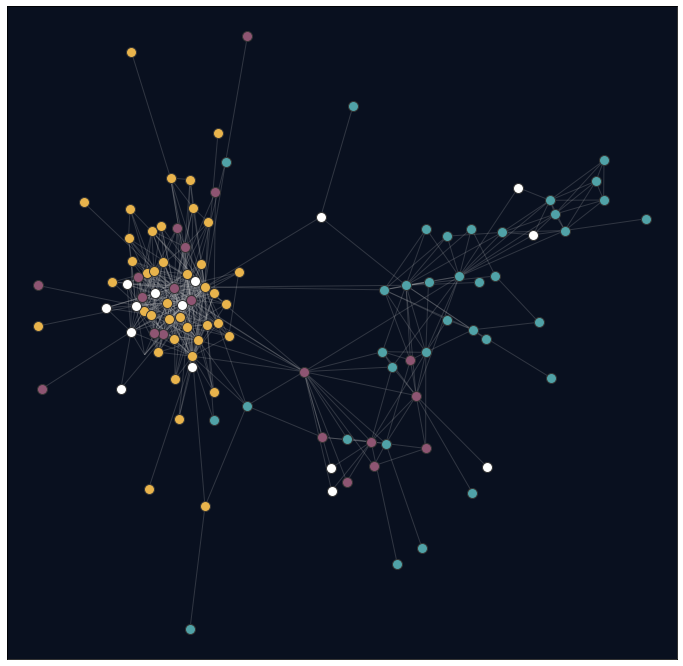

In [168]:
fig, ax = plt.subplots(1,1,figsize=(12,12))         



nx.draw_networkx_edges(g, pos, edgelist=g.edges(),
        edge_color = '0.8',
        alpha=0.2,
        ax=ax)

for fid in field2node.keys():
    nx.draw_networkx_nodes(g.subgraph(field2node[fid]), pos,
        node_size= 100, 
        node_color=field2color[fid], 
        edgecolors='0.2', # node outline
                       vmax = 5,
        ax = ax)
    print(fid, field2node[fid], len(g.subgraph(field2node[fid])))

ax.set_facecolor('#09101F')

#plt.savefig('DiversityCocitiation.pdf')
plt.show()